# Imports

In [17]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [18]:
apple = cv2.imread('apple.jpg')
orange = cv2.imread('orange.jpg')

# Resize the apple image to match the height of the orange image
apple_resized = cv2.resize(apple, (orange.shape[1], orange.shape[0]))

print(apple_resized.shape)
print(orange.shape)

# Now, both images should have the same height
apple_orange = np.hstack((apple_resized[:, :256], orange[:, 256:]))

(524, 533, 3)
(524, 533, 3)


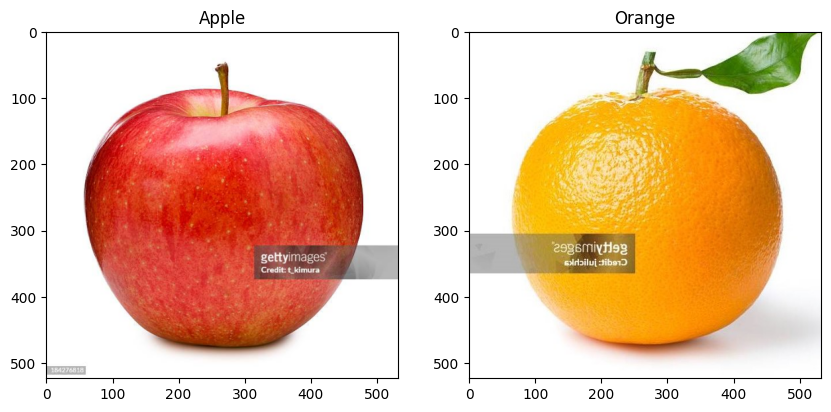

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(apple_resized, cv2.COLOR_BGR2RGB))
plt.title('Apple')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB))
plt.title('Orange')

plt.show()

In [20]:
# generate Gaussian pyramid for apple
apple_copy = apple.copy()
gp_apple = [apple_copy]

for i in range(6):
    apple_copy = cv2.pyrDown(apple_copy)
    gp_apple.append(apple_copy)

In [21]:
# generate Gaussian pyramid for orange
orange_copy = orange.copy()
gp_orange = [orange_copy]

for i in range(6):
    orange_copy = cv2.pyrDown(orange_copy)
    gp_orange.append(orange_copy)

In [22]:
# generate Laplacian Pyramid for apple
apple_copy = gp_apple[5]
lp_apple = [apple_copy]

for i in range(5, 0, -1):
    gaussian_expanded = cv2.pyrUp(gp_apple[i])

    # Resize gaussian_expanded to match the dimensions of gp_apple[i-1]
    gaussian_expanded_resized = cv2.resize(gaussian_expanded, (gp_apple[i-1].shape[1], gp_apple[i-1].shape[0]))

    laplacian = cv2.subtract(gp_apple[i-1], gaussian_expanded_resized)
    lp_apple.append(laplacian)

In [23]:
# generate Laplacian Pyramid for orange
orange_copy = gp_orange[5]
lp_orange = [orange_copy]

for i in range(5, 0, -1):
    gaussian_expanded = cv2.pyrUp(gp_orange[i])

    # Resize gaussian_expanded to match the dimensions of gp_orange[i-1]
    gaussian_expanded_resized = cv2.resize(gaussian_expanded, (gp_orange[i-1].shape[1], gp_orange[i-1].shape[0]))

    laplacian = cv2.subtract(gp_orange[i-1], gaussian_expanded_resized)
    lp_orange.append(laplacian)

In [24]:
# Now add left and right halves of images in each level
apple_orange_pyramid = []

for apple_lap, orange_lap in zip(lp_apple, lp_orange):
    # Resize orange_lap to match the shape of apple_lap
    orange_lap_resized = cv2.resize(orange_lap, (apple_lap.shape[1], apple_lap.shape[0]))

    # Stack apple_lap and resized orange_lap horizontally
    laplacian = np.hstack((apple_lap[:, :int(apple_lap.shape[1]/2)], orange_lap_resized[:, int(apple_lap.shape[1]/2):]))

    apple_orange_pyramid.append(laplacian)


In [25]:
# now reconstruct
apple_orange_reconstruct = apple_orange_pyramid[0]

for i in range(1, 6):
    # Upsample the reconstructed image to match the size of the current pyramid level
    apple_orange_reconstruct = cv2.pyrUp(apple_orange_reconstruct)

    # Ensure compatibility by resizing the pyramid level to match the size of the reconstructed image
    resized_pyramid_level = cv2.resize(apple_orange_pyramid[i], (apple_orange_reconstruct.shape[1], apple_orange_reconstruct.shape[0]))

    # Add the resized pyramid level to the reconstructed image
    apple_orange_reconstruct = cv2.add(resized_pyramid_level, apple_orange_reconstruct)

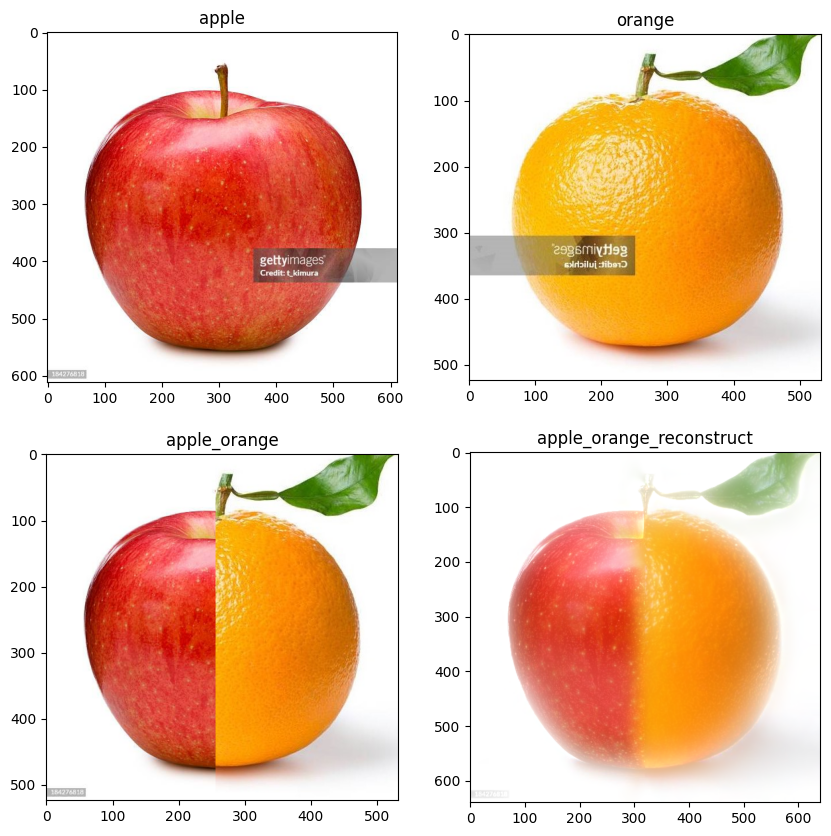

In [28]:
# Showing the results in a subbplot.
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(apple, cv2.COLOR_BGR2RGB))
plt.title('apple')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB))
plt.title('orange')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(apple_orange, cv2.COLOR_BGR2RGB))
plt.title('apple_orange')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(apple_orange_reconstruct, cv2.COLOR_BGR2RGB))
plt.title('apple_orange_reconstruct')

plt.show()

# Same code but done with functions so that we can input different images and just call the function.

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def resize_images_to_match(image1, image2):
    return cv2.resize(image1, (image2.shape[1], image2.shape[0]))

In [31]:
def generate_laplacian_pyramid(image, levels=6):
    # Generate Gaussian pyramid
    gaussian_pyr = [image.copy()]
    for _ in range(levels):
        image = cv2.pyrDown(image)
        gaussian_pyr.append(image)

    # Generate Laplacian pyramid
    laplacian_pyr = [gaussian_pyr[-1]]
    for i in range(levels-1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i+1])
        laplacian = cv2.subtract(gaussian_pyr[i], cv2.resize(gaussian_expanded, (gaussian_pyr[i].shape[1], gaussian_pyr[i].shape[0])))
        laplacian_pyr.append(laplacian)

    return laplacian_pyr

In [32]:
def reconstruct_from_laplacian_pyramid(laplacian_pyr):
    reconstructed_image = laplacian_pyr[0]
    for i in range(1, len(laplacian_pyr)):
        reconstructed_image = cv2.pyrUp(reconstructed_image)
        reconstructed_image = cv2.add(reconstructed_image, cv2.resize(laplacian_pyr[i], (reconstructed_image.shape[1], reconstructed_image.shape[0])))
    return reconstructed_image

In [33]:
def blend_images(image1, image2):
    image1_resized = resize_images_to_match(image1, image2)

    # Generate Laplacian pyramid for image1
    image1_laplacian_pyr = generate_laplacian_pyramid(image1_resized)

    # Generate Laplacian pyramid for image2
    image2_laplacian_pyr = generate_laplacian_pyramid(image2)

    blended_pyr = []
    for image1_lap, image2_lap in zip(image1_laplacian_pyr, image2_laplacian_pyr):
        image2_lap_resized = cv2.resize(image2_lap, (image1_lap.shape[1], image1_lap.shape[0]))
        blended = np.hstack((image1_lap[:, :int(image1_lap.shape[1]/2)], image2_lap_resized[:, int(image1_lap.shape[1]/2):]))
        blended_pyr.append(blended)

    blended_image = reconstruct_from_laplacian_pyramid(blended_pyr)
    return blended_image

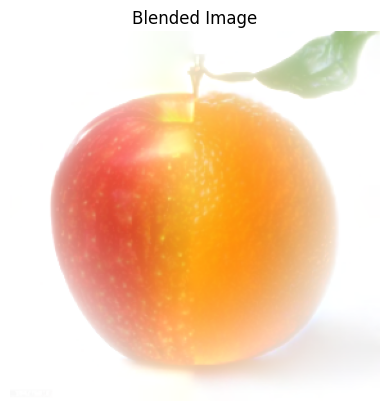

In [34]:
# Test the function with apple and orange images
apple = cv2.imread('apple.jpg')
orange = cv2.imread('orange.jpg')

blended_image = blend_images(apple, orange)

# Display the result
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()

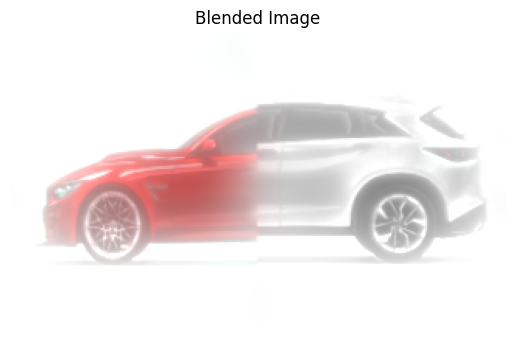

In [35]:
# Test the function with apple and orange images
red_car = cv2.imread('red_car.jpg')
white_car = cv2.imread('white_car.jpg')

blended_image = blend_images(red_car, white_car)

# Display the result
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')
plt.show()